#  Analysis Part 3: Scan over the NN settings

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
import random
import pickle
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d
from madminer.plotting import plot_fisherinfo_barplot
from madminer.plotting import plot_distribution_of_information

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

## 1. Define Path and Files

In [2]:
usenamein='100k'
nsamples=50000

useinputdata = 'data/madminer_wgamma_observables_'+usenamein+'.h5'
usesamplesdir = 'data/refscan_'+usenamein+'/'
usemodelsdir = 'models/refscan_'+usenamein+'/'
usesummaryfile = 'data/refscan_'+usenamein+'/summary.npy'

## 2. Make (unweighted) training and test samples with augmented data

In [3]:
#create sample augmenter
sa = SampleAugmenter(useinputdata, debug=False)

#augment train sample
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=nsamples,
    folder='./'+usesamplesdir,
#    test_split=None,
    filename='train'
)

#augment test sample
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=nsamples,
    folder='./'+usesamplesdir,
#    test_split=None,
    filename='test',
    switch_train_test_events=True
)


18:59  
18:59  ------------------------------------------------------------
18:59  |                                                          |
18:59  |  MadMiner v2018.11.09                                    |
18:59  |                                                          |
18:59  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
18:59  |                                                          |
18:59  ------------------------------------------------------------
18:59  
18:59  Loading data from data/madminer_wgamma_observables_100k.h5
18:59  Found 2 parameters:
18:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:59  Found 6 benchmarks:
18:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
18:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
18:59     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
18:59     morphing_basis_vector_3: CWL2 = 17.32, CPW

## 3. Scan

### 3a) Define Settings

In [3]:
#Number of epochs
choices_epochs = [50] 
choices_nhidden = [2,3,4,5,6,7]
choices_nneuron = [20,50,100,200]
choices_activation = ['tanh', 'sigmoid', 'relu']
choices_regularization = [None]  
choices_lrinitial = [0.1,0.01,0.001,0.0001]
choices_lrratio = [1,10,100,1000] 
choices_trainer = ['amsgrad'] 
choices_validation = [None,0.25,0.5]

### 3b) Scan over Settings

In [4]:
# read file
if os.path.isfile(usesummaryfile):
    summary=np.load(usesummaryfile)
else:
    summary=np.array([])
n0scan=len(summary)

#scan nscan possible settings
nscan=1
for iscan in range (n0scan,n0scan+nscan):
    #Output
    print ('Do Run Number ', iscan-n0scan , ' out of ', nscan)
    
    #choose settings randomly
    index_epochs=random.randint(0,len(choices_epochs)-1)
    index_nhidden=random.randint(0,len(choices_nhidden)-1)
    index_nneuron=random.randint(0,len(choices_nneuron)-1)
    index_activation=random.randint(0,len(choices_activation)-1)
    index_regularization=random.randint(0,len(choices_regularization)-1)
    index_lrinitial=random.randint(0,len(choices_lrinitial)-1)
    index_lrratio=random.randint(0,len(choices_lrratio)-1)
    index_trainer=random.randint(0,len(choices_trainer)-1)
    index_validation=random.randint(0,len(choices_validation)-1)

    this_nhidden = choices_nhidden[index_nhidden]
    this_nneuron = choices_nneuron[index_nneuron]
    this_lrinitial = choices_lrinitial[index_lrinitial]
    this_lrratio = choices_lrratio[index_lrratio]
    
    this_epochs = choices_epochs[index_epochs]
    this_hidden = tuple( [ this_nneuron for i in range(this_nhidden)] )
    this_activation = choices_activation[index_activation]
    this_regularization = choices_regularization[index_regularization]
    this_learning = ( this_lrinitial,this_lrinitial/this_lrratio )
    this_trainer = choices_trainer[index_trainer]
    this_validation = choices_validation[index_validation]
    
    #Setup/train/save ensemble
    forge = MLForge()
    """
    if iscan==0:
        forge.train(
            method='sally',
            x_filename=usesamplesdir+'x_train.npy',
            t_xz0_filename=usesamplesdir+'t_xz_train.npy'
        )   
    else: 
        forge.train(
            method='sally',
            x_filename=usesamplesdir+'x_train.npy',
            t_xz0_filename=usesamplesdir+'t_xz_train.npy',
            batch_size=128,
            n_epochs=this_epochs,
            n_hidden=this_hidden,
            activation=this_activation,
            grad_x_regularization=this_regularization,
            initial_lr=this_learning[0],
            final_lr=this_learning[1],
            trainer=this_trainer,
            validation_split=this_validation,
        )
    """
    forge.train(
        method='sally',
        x_filename=usesamplesdir+'x_train.npy',
        t_xz0_filename=usesamplesdir+'t_xz_train.npy',
        nde_type="mafmog",
        n_hidden=(100, 100, 100, 100),
        activation="tanh",
        maf_n_mades=3,
        maf_batch_norm=False,
        maf_batch_norm_alpha=0.1,
        maf_mog_n_components=10,
        alpha=1.0,
        trainer="amsgrad",
        n_epochs=50,
        batch_size=128,
        initial_lr=0.01,
        final_lr=0.0001,
        nesterov_momentum=None,
        validation_split=None,
        early_stopping=True,
        scale_inputs=True,
        grad_x_regularization=None
    )
    modelsavefile=usemodelsdir+'setup_{}/sally_test'.format(iscan)
    forge.save(modelsavefile)
    
    #Fisher Info 
    fisher = FisherInformation(useinputdata, debug=False)
    fi_mean , _ = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,return_error=True,
        model_file=modelsavefile,
        unweighted_x_sample_file=usesamplesdir+'x_test.npy'
    )
    
    #Scores and MSE
    t_pl_test=np.load(usesamplesdir+'t_xz_test.npy')
    t_ml_test=forge.evaluate(usesamplesdir+'x_test.npy')
    t_mse = mean_squared_error(t_pl_test,t_ml_test)
    
    #Save everything
    newelement= [iscan,
                 index_validation,index_nhidden,index_nneuron,index_activation,index_regularization,
                 index_lrinitial,index_lrratio,index_trainer,
                 np.linalg.det(fi_mean),
                 t_mse
                ]
#    summary.append(newelement)
    if len(summary)==0:
        summary= [newelement]
    else:
        summary = np.append(summary, [newelement],axis=0) 
    
#Save 
np.save(usesummaryfile,summary)

08:56  
08:56  ------------------------------------------------------------
08:56  |                                                          |
08:56  |  MadMiner v2018.11.09                                    |
08:56  |                                                          |
08:56  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
08:56  |                                                          |
08:56  ------------------------------------------------------------
08:56  
08:56  Starting training
08:56    Method:                 sally
08:56    Training data: x at data/refscan_100k/x_train.npy
08:56                   t_xz (theta0) at  data/refscan_100k/t_xz_train.npy
08:56    Features:               all
08:56    Method:                 sally
08:56    Hidden layers:          (100, 100, 100, 100)
08:56    Activation function:    tanh
08:56    Batch size:             128
08:56    Trainer:                amsgrad
08:56    Epochs:                 50
08:56    Learning rate:     

Do Run Number  0  out of  1


08:56  Creating model for method sally
08:56  Training model
08:56    Epoch 5: train loss 0.0002 (mse_score: 0.0002)
08:57    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
08:57    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
08:57    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
08:57    Epoch 25: train loss 0.0000 (mse_score: 0.0000)
08:57    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
08:57    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
08:57    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
08:57    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
08:57    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
08:57  Finished training
08:57  Loading data from data/madminer_wgamma_observables_100k.h5
08:57  Found 2 parameters:
08:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:57     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:57  Found 6 benchmarks:
08:57     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
08:5

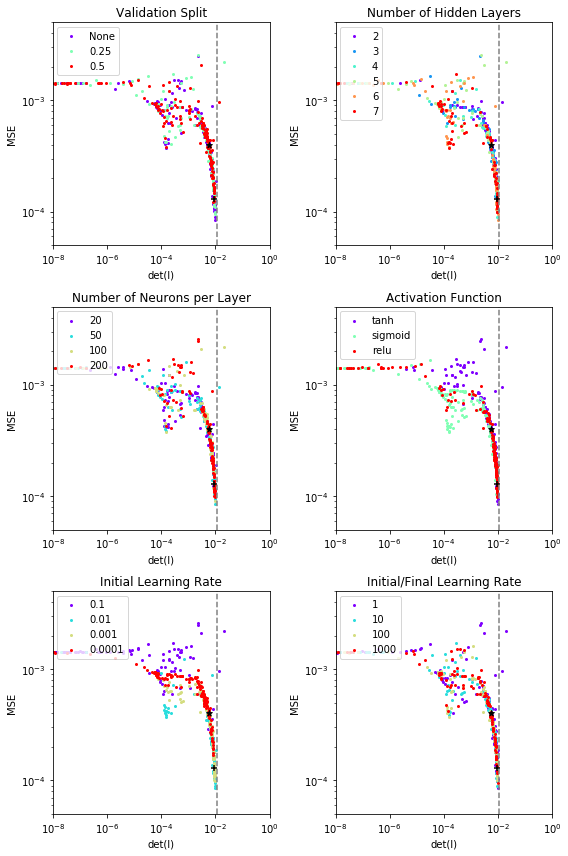

In [9]:
#######
#Truth FisherInfo
fi_truth , _= fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000.)
fidet_truth=np.linalg.det(fi_truth)

#######
#Input Data
data = np.load(usesummaryfile)

#######
#List Manipulation
def sublist(inputlist, index, condition):
    outputlist=[]
    for ilist in range(len(inputlist)):
        if inputlist[ilist,index]==condition:
            outputlist.append(inputlist[ilist])
    return np.array(outputlist)

#######
#Figure
myrangex=[10**(-8),1]
myrangey=[5*10**(-5),.005]
mysize=4
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2)
f.set_size_inches(8,12)
nnew=500

# choices_validation split
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_validation)))
for i in range(len(choices_validation)):
    thisdata=sublist(data,1,i)
    ax1.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_validation[i]))
ax1.scatter(data[0,9], data[0,10],color='black',marker="*")
ax1.scatter(data[nnew,9], data[nnew,10],color='black',marker="+")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('det(I)')
ax1.set_ylabel('MSE')
ax1.set_xlim(myrangex)
ax1.set_ylim(myrangey)
ax1.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax1.set_title('Validation Split')
ax1.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nhidden
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nhidden)))
for i in range(len(choices_nhidden)):
    thisdata=sublist(data,2,i)
    ax2.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nhidden[i]))
ax2.scatter(data[0,9], data[0,10],color='black',marker="*")
ax2.scatter(data[nnew,9], data[nnew,10],color='black',marker="+")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I)')
ax2.set_ylabel('MSE')
ax2.set_xlim(myrangex)
ax2.set_ylim(myrangey)
ax2.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax2.set_title('Number of Hidden Layers')
ax2.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nneuron
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nneuron)))
for i in range(len(choices_nneuron)):
    thisdata=sublist(data,3,i)
    ax3.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nneuron[i]))
ax3.scatter(data[0,9], data[0,10],color='black',marker="*")
ax3.scatter(data[nnew,9], data[nnew,10],color='black',marker="+")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('det(I)')
ax3.set_ylabel('MSE')
ax3.set_xlim(myrangex)
ax3.set_ylim(myrangey)
ax3.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax3.set_title('Number of Neurons per Layer')
ax3.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_activation
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_activation)))
for i in range(len(choices_activation)):
    thisdata=sublist(data,4,i)
    ax4.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_activation[i]))
ax4.scatter(data[0,9], data[0,10],color='black',marker="*")
ax4.scatter(data[nnew,9], data[nnew,10],color='black',marker="+")
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('det(I)')
ax4.set_ylabel('MSE')
ax4.set_xlim(myrangex)
ax4.set_ylim(myrangey)
ax4.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax4.set_title('Activation Function')
ax4.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrinitial)))
for i in range(len(choices_lrinitial)):
    thisdata=sublist(data,6,i)
    ax5.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrinitial[i]))
ax5.scatter(data[0,9], data[0,10],color='black',marker="*")
ax5.scatter(data[nnew,9], data[nnew,10],color='black',marker="+")
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel('det(I)')
ax5.set_ylabel('MSE')
ax5.set_xlim(myrangex)
ax5.set_ylim(myrangey)
ax5.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax5.set_title('Initial Learning Rate')
ax5.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrratio)))
for i in range(len(choices_lrratio)):
    thisdata=sublist(data,7,i)
    ax6.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrratio[i]))
ax6.scatter(data[0,9], data[0,10],color='black',marker="*")
ax6.scatter(data[nnew,9], data[nnew,10],color='black',marker="+")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_xlabel('det(I)')
ax6.set_ylabel('MSE')
ax6.set_xlim(myrangex)
ax6.set_ylim(myrangey)
ax6.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax6.set_title('Initial/Final Learning Rate')
ax6.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

#######
#Plot
plt.tight_layout()
plt.show()

In [7]:
#Get list of good settings
data_sort = data[data[:,10].argsort()[::1]][:5,:]

for i in range(len(data_sort)):
    print ('Setting with det(I)=',data_sort[i,9],'and MSE=',data_sort[i,10], 'had settings')
    print (' - Validation Split:',choices_validation[int(data_sort[i,1])])
    print (' - Number of Hidden Layers:',choices_nhidden[int(data_sort[i,2])])
    print (' - Number of Neurons per Layer:',choices_nneuron[int(data_sort[i,3])])
    print (' - Activation Function:',choices_activation[int(data_sort[i,4])])
    print (' - Regularization Parameter:',choices_regularization[int(data_sort[i,5])])
    print (' - Initial Learning Rate:',choices_lrinitial[int(data_sort[i,6])])
    print (' - Final Learning Rate:',choices_lrinitial[int(data_sort[i,6])]/choices_lrratio[int(data_sort[i,7])])
    print (' - Trainer:',choices_trainer[int(data_sort[i,8])])
    print ('')

Setting with det(I)= 0.010028179025994986 and MSE= 8.469977060316645e-05 had settings
 - Validation Split: None
 - Number of Hidden Layers: 6
 - Number of Neurons per Layer: 50
 - Activation Function: tanh
 - Regularization Parameter: None
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 0.01
 - Trainer: amsgrad

Setting with det(I)= 0.009303214400776787 and MSE= 8.969399461947169e-05 had settings
 - Validation Split: None
 - Number of Hidden Layers: 4
 - Number of Neurons per Layer: 100
 - Activation Function: tanh
 - Regularization Parameter: None
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 0.001
 - Trainer: amsgrad

Setting with det(I)= 0.009584518408789811 and MSE= 9.463262112638035e-05 had settings
 - Validation Split: 0.25
 - Number of Hidden Layers: 6
 - Number of Neurons per Layer: 50
 - Activation Function: tanh
 - Regularization Parameter: None
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 1e-05
 - Trainer: amsgrad

Setting with det(I)= 0.00936611176